###START WEEK1_ANALYSIS
# This script performs initial data analysis for the Pollution Drift Predictor project.

In [ ]:
# It loads the dataset, checks for missing values, and provides basic statistics.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(".."))  # Adds project root to Python path
sys.path.append(os.path.abspath("."))  # Adds current directory to Python path


In [7]:
df = pd.read_csv("../data/data.csv", encoding='ISO-8859-1', engine='python')
print(df.columns.tolist())

df.head()         # To preview the first few rows  
df.info()         # To check column types and non-null counts  
df.describe()
df.isnull().sum()



['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  4

stn_code                       144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
dtype: int64

In [11]:
# Drop Sparse or Irrelevant Columns
df.drop(columns=['pm2_5', 'sampling_date', 'stn_code', 'location_monitoring_station'], errors='ignore', inplace=True)


### 📊 Distribution & Transformation of Pollutants
- Visualized boxplots for SO₂, NO₂, and SPM
- Printed skewness to assess distribution shape
- Applied log transformation to SPM and RSPM to reduce skewness


Skewness:
so2     8.521066
no2     3.676816
rspm    3.213677
spm     1.585091
dtype: float64


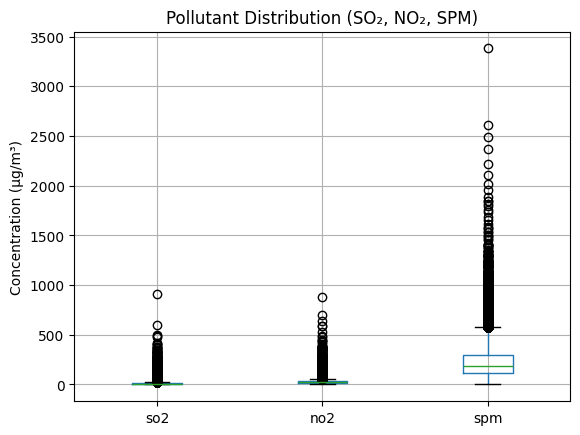

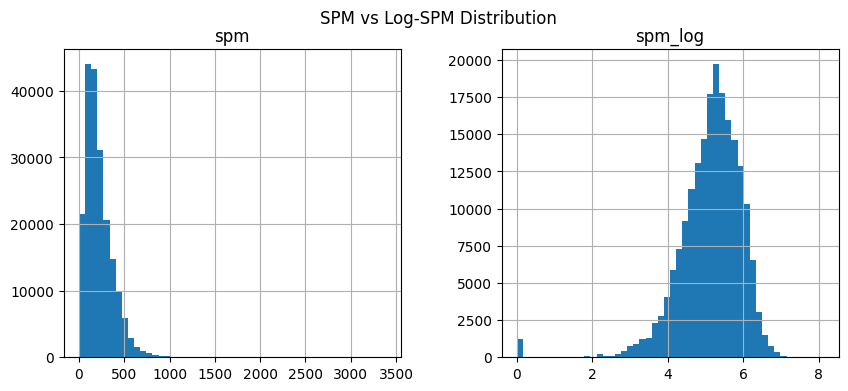

In [12]:
# Distribution of Key Pollutants
df[['so2', 'no2', 'spm']].boxplot()

print("Skewness:")
print(df[['so2', 'no2', 'rspm', 'spm']].skew())

df['spm_log'] = np.log1p(df['spm'])
df['rspm_log'] = np.log1p(df['rspm'])

plt.title("Pollutant Distribution (SO₂, NO₂, SPM)")
plt.ylabel("Concentration (µg/m³)")
plt.grid(True)
plt.show()

# HISTOGRAM
df[['spm', 'spm_log']].hist(bins=50, figsize=(10, 4))
plt.suptitle("SPM vs Log-SPM Distribution")
plt.show()


### 🌍 Average SPM by State
- Grouped data by `state` to analyze regional pollution levels
- Visualized mean SPM concentrations across states
- Can help identify high-risk regions or inform feature engineering


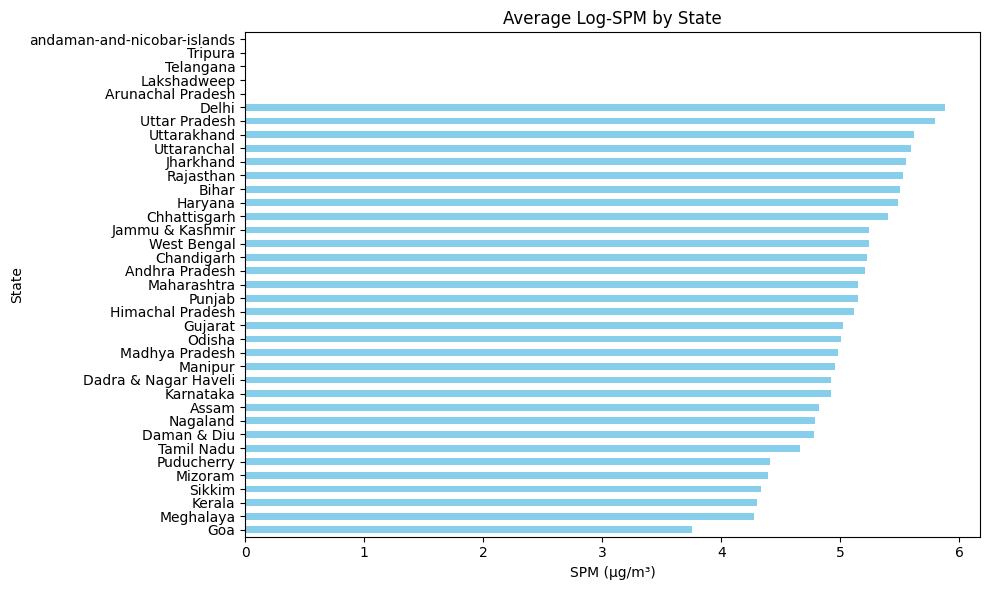

In [13]:
# Average SPM by State
df.groupby('state')['spm_log'].mean().sort_values().plot(kind='barh', figsize=(10,6), color='skyblue')
plt.title("Average Log-SPM by State")
plt.xlabel("SPM (µg/m³)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


### 📍 Average SPM in Top 10 Locations
- Selected top 10 locations based on frequency of records
- Calculated and visualized average SPM levels
- Highlights regional pollution hotspots and potential modeling features


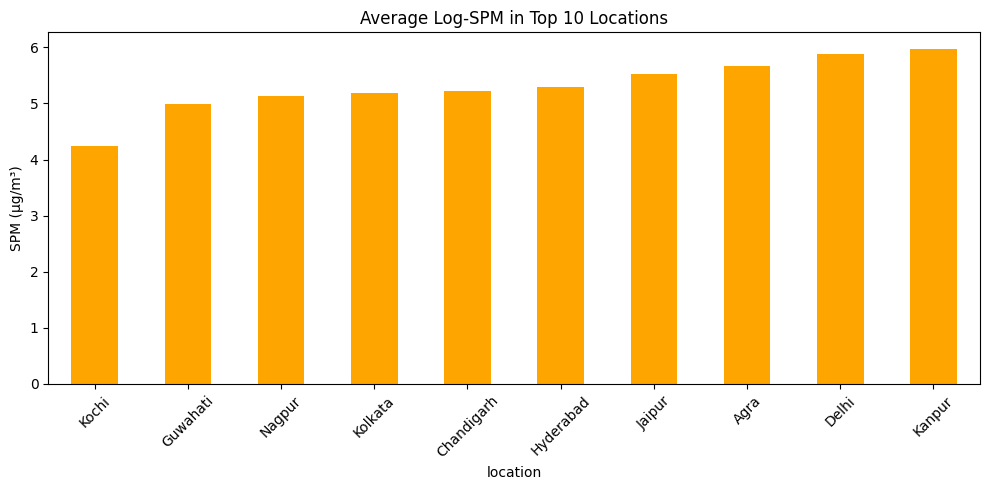

In [15]:
# Average SPM in Top 10 Locations

top_locations = df['location'].value_counts().head(10).index
df[df['location'].isin(top_locations)].groupby('location')['spm_log'].mean().sort_values().plot(kind='bar', figsize=(10,5), color='orange')
plt.title("Average Log-SPM in Top 10 Locations")
plt.ylabel("SPM (µg/m³)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##To SAVE
os.makedirs("../outputs", exist_ok=True)
plt.savefig("../outputs/top10_spm_locations.png", bbox_inches='tight')


### 🔥 Correlation Matrix of Pollutants
- Visualized linear relationships between SO₂, NO₂, and SPM
- Helps identify multicollinearity and feature relevance
- Will guide feature selection for modeling


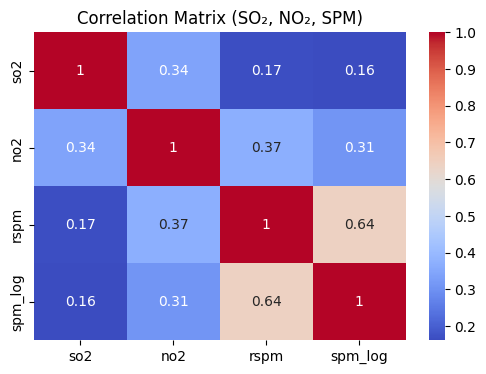

In [18]:
# Correlation Heatmapss

plt.figure(figsize=(6,4))
sns.heatmap(df[['so2', 'no2', 'rspm', 'spm_log']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (SO₂, NO₂, SPM)")
plt.show()


### 📅 Monthly Average SPM Over Time
- Used `date` column for time-based resampling
- Visualized monthly average SPM trends using log-transformed values


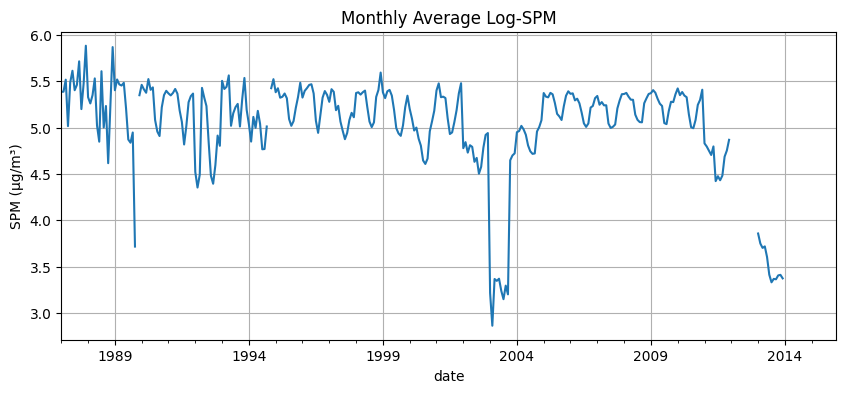

In [23]:
# Time Series of Monthly Average SPM

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.set_index('date')['spm_log'].resample('ME').mean().plot(figsize=(10,4))
plt.title("Monthly Average Log-SPM")
plt.ylabel("SPM (µg/m³)")
plt.grid(True)
plt.show()

##To SAVE
os.makedirs("../outputs", exist_ok=True)
plt.savefig("../outputs/monthly_spm_trend.png", bbox_inches='tight')



### 🧹 Filtered Dataset for Modeling
- Created `df_clean` by dropping rows with missing values in `so2`, `no2`, and `spm`
- Ensures clean input for regression and avoids NaN-related errors


In [30]:
# Drop rows with missing values in relevant columns
df_clean = df[['so2', 'no2', 'spm', 'spm_log', 'rspm_log']].dropna()


### 🤖 Linear Regression Model
- Trained a linear regression model using `so2` and `no2` as features
- Evaluated performance using R², MAE, MSE, and custom accuracy
- This serves as a baseline model for comparison with more flexible algorithms


In [33]:
#USING LINEAR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Feature and target
X = df_clean[['so2', 'no2', 'rspm_log']]
y = df_clean['spm_log']  # log-transformed target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict (log scale)
y_pred_log = model.predict(X_test)

# Inverse transform to original scale
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Evaluate
r2 = r2_score(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
error_percent = (mae / y_test_original.mean()) * 100
tolerance = 0.1 * y_test_original.mean()
accuracy = np.mean(np.abs(y_pred - y_test_original) < tolerance) * 100

# Print summary
print(f"R² Score        : {r2:.4f}")
print(f"MAE             : {mae:.2f}")
print(f"MSE             : {mse:.2f}")
print(f"Error Percentage: {error_percent:.2f}%")
print(f"Custom Accuracy : {accuracy:.2f}%")

#To SAVE THE MODEL
os.makedirs("../models", exist_ok=True)
import joblib
joblib.dump(model, "../models/linear_regression_model.pkl")


R² Score        : 0.6454
MAE             : 58.04
MSE             : 8167.98
Error Percentage: 25.76%
Custom Accuracy : 33.85%


['../models/linear_regression_model.pkl']

### RANDOM FOREST REGRESSOR

In [34]:
#USING RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Feature and target
X = df_clean[['so2', 'no2', 'rspm_log']]
y = df_clean['spm_log']  # log-transformed target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict (log scale)
y_pred_log = model.predict(X_test)

# Inverse transform to original scale
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Evaluate
r2 = r2_score(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
error_percent = (mae / y_test_original.mean()) * 100
tolerance = 0.1 * y_test_original.mean()
accuracy = np.mean(np.abs(y_pred - y_test_original) < tolerance) * 100

# Print summary
print(f"R² Score        : {r2:.4f}")
print(f"MAE             : {mae:.2f}")
print(f"MSE             : {mse:.2f}")
print(f"Error Percentage: {error_percent:.2f}%")
print(f"Custom Accuracy : {accuracy:.2f}%")

#To SAVE THE MODEL
os.makedirs("../models", exist_ok=True)
import joblib
joblib.dump(model, "../models/random_forest_model.pkl")



R² Score        : 0.6911
MAE             : 52.16
MSE             : 7114.37
Error Percentage: 23.16%
Custom Accuracy : 40.54%


['../models/random_forest_model.pkl']

### 🔄 Model Comparison
- Linear Regression: Fast, interpretable baseline
- Random Forest: Better accuracy and error reduction
- Future work: Hyperparameter tuning and feature expansion


### ✅ Week 1 Summary

- **Data Cleaning & Preparation**: Sparse and irrelevant columns were dropped, missing values imputed, and log transformations applied to reduce skewness in pollutant distributions.
- **Exploratory Analysis**: Boxplots, histograms, and grouped bar charts revealed pollutant spread, regional pollution hotspots, and temporal trends using monthly averages.
- **Feature Engineering**: Log-transformed `spm` and `rspm` were introduced to improve model stability. Temporal features (`month`, `year`) and categorical variables (`type`, `location`) were considered for future modeling.
- **Correlation Insights**: SO₂, NO₂, and RSPM showed meaningful correlation with SPM, validating their use as predictive features.
- **Modeling**: Both Linear Regression and Random Forest Regressor were trained using `so2`, `no2`, and `rspm_log` to predict `spm_log`. Random Forest outperformed linear regression across all metrics.
- **Evaluation Metrics**: R², MAE, MSE, Error %, and Custom Accuracy were calculated to benchmark model performance and guide Week 2 improvements.
- **Model Comparison**: Random Forest was retained for its superior accuracy and robustness, establishing a strong baseline for future enhancements.
